#**Brain Tumor Detection using CNN**

**Introduction**

Brain tumors are abnormal growths of cells in the brain, which can be either benign or malignant. Early and accurate detection of brain tumors is critical for effective treatment and improved patient outcomes. Magnetic Resonance Imaging (MRI) is a non-invasive imaging technique that provides detailed images of the brain's structure, making it a valuable tool for diagnosing brain tumors.

**Problem Statement**

The objective of this project is to develop a deep learning model using Convolutional Neural Networks (CNNs) to detect and classify brain tumors from MRI images. The model aims to automate the diagnosis process, thereby assisting radiologists and medical practitioners in identifying brain tumors more efficiently and accurately.

**dataset link** : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

#**Importing Necessary Libraries**

In [30]:
import pandas as pd,numpy as np,matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report,confusion_matrix,roc_curve,auc

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense,Dropout,Input,BatchNormalization

from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

#**Collecting Dataset**

In [31]:
import zipfile

z=zipfile.ZipFile('/content/Brain MRI Images for Brain Tumor Detection.zip')
z.extractall()
z.close()

In [32]:
#load dataset directories
no_tumor_dir = '/content/brain_tumor_dataset/no'
yes_tumor_dir = '/content/brain_tumor_dataset/yes'

In [33]:
#function to load images
def load_images_from_folder(folder):
  images = []
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
      img = cv2.resize(img,(128,128))
      images.append(img)
  return images

In [34]:
#load images
no_tumor_images = load_images_from_folder(no_tumor_dir)
yes_tumor_images = load_images_from_folder(yes_tumor_dir)

**labels are necessary for supervised learning, where the model needs both the input data (images) and the corresponding output labels (indicating the presence or absence of a tumor) to learn from during training.**

In [35]:
[0] * len(no_tumor_images)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [36]:
#create labels

no_tumor_labels = [0] * len(no_tumor_images)
yes_tumor_lables = [1] * len(yes_tumor_images)

In [37]:
#Combine data and labels

X = np.array(no_tumor_images + yes_tumor_images)
y = np.array(no_tumor_labels + yes_tumor_lables)

#**Data Preprocessing**

**Why Normalize: Images are typically represented as arrays of pixel values ranging from 0 to 255. Normalizing these values to a range of 0 to 1 helps the model train more efficiently and can improve the performance and convergence speed of neural networks**

In [38]:
# Data Preprocessing
X = X / 255.0
y = to_categorical(y, num_classes=2)

In [39]:
#spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'

)
datagen.fit(X_train)

**Data augmentation helps to increase the diversity of your training dataset by applying various transformations to the images. This helps in preventing overfitting and improves the model's generalization ability.**

#**Model Building(Transfer Learning with VGG16)**

In [41]:
#use transfer learning (VGG16)
base_model = VGG16(weights="imagenet",include_top=False,input_shape =(128,128,3))
base_model.trainable = False

In [42]:
#Add custom layers
input_layer = Input(shape=(128,128,3))
x  = base_model(input_layer,training=False)
x = Flatten()(x)
x = Dense(256,activation = "relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(2,activation = "softmax")(x)

model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [43]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [44]:
#Model training
history = model.fit(datagen.flow(X_train,y_train,batch_size=32),
                    epochs=25,validation_data=(X_test,y_test),
                    callbacks = [early_stopping])

Epoch 1/25
7/7 [==============================] - 64s 9s/step - loss: 1.0990 - accuracy: 0.6188 - val_loss: 0.9489 - val_accuracy: 0.6471
Epoch 2/25
7/7 [==============================] - 61s 9s/step - loss: 0.6813 - accuracy: 0.7525 - val_loss: 1.2135 - val_accuracy: 0.6667
Epoch 3/25
7/7 [==============================] - 61s 9s/step - loss: 0.7628 - accuracy: 0.7277 - val_loss: 1.1705 - val_accuracy: 0.6471
Epoch 4/25
7/7 [==============================] - 52s 8s/step - loss: 0.5933 - accuracy: 0.7673 - val_loss: 0.6467 - val_accuracy: 0.6863
Epoch 5/25
7/7 [==============================] - 50s 7s/step - loss: 0.5955 - accuracy: 0.7475 - val_loss: 0.2565 - val_accuracy: 0.9216
Epoch 6/25
7/7 [==============================] - 59s 9s/step - loss: 0.4093 - accuracy: 0.8020 - val_loss: 0.1878 - val_accuracy: 0.8824
Epoch 7/25
7/7 [==============================] - 51s 7s/step - loss: 0.4801 - accuracy: 0.8119 - val_loss: 0.2468 - val_accuracy: 0.8627
Epoch 8/25
7/7 [==================

In [45]:
model.save('brain_tumor_detection_model.h5')

**Visualization**

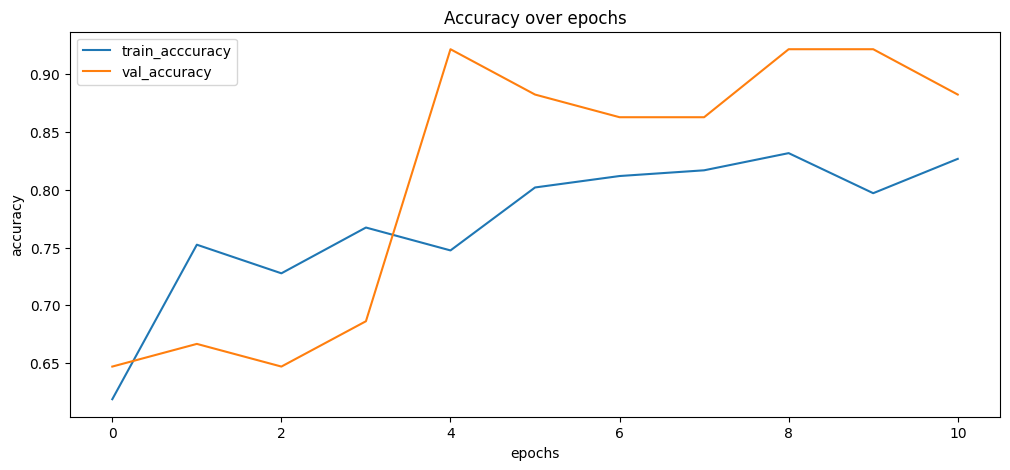

In [46]:
#plotting train/val accuracy

plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],label = "train_acccuracy")
plt.plot(history.history['val_accuracy'],label = "val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

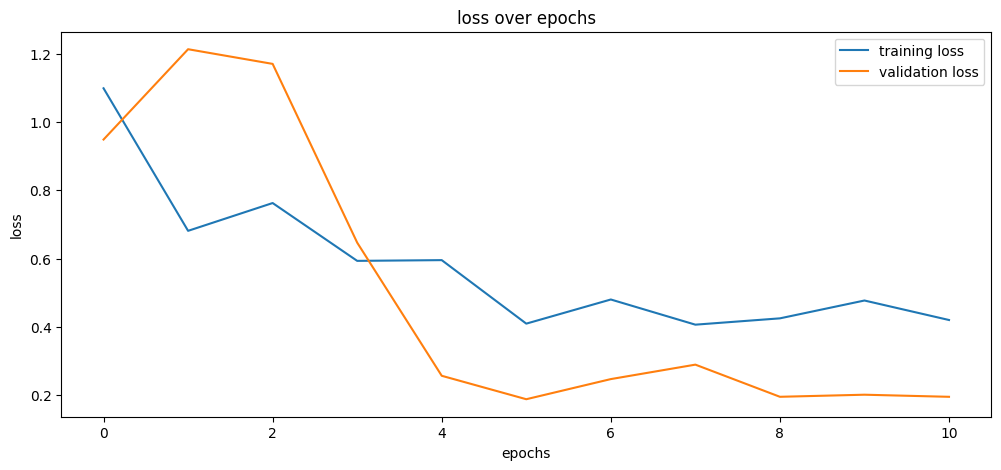

In [47]:
#plotting train/val loss

plt.figure(figsize=(12,5))
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

#**Model Evaluation**

In [48]:
#model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1)

2/2 [==============================] - 10s 3s/step


In [49]:
#classification report and confusion matrix
print("classification report:\n", classification_report(y_true,y_pred_classes))
print("confusion matrix:\n",confusion_matrix(y_true,y_pred_classes))

classification report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        20
           1       0.93      0.87      0.90        31

    accuracy                           0.88        51
   macro avg       0.87      0.89      0.88        51
weighted avg       0.89      0.88      0.88        51

confusion matrix:
 [[18  2]
 [ 4 27]]


**Model Training Analysis**

**Accuracy and Loss Over Epochs**

🟢 **Accuracy over Epochs**
* **Training Accuracy (blue)**: Steadily increases, indicating learning.
* **Validation Accuracy (orange)**: Generally higher but fluctuates, showing good performance on unseen data with some instability.


🔵 **loss over Epochs**
* **Training Loss (blue)**: Rapid initial decrease, then gradual decline, indicating good fit.
***Validation Loss (orange)**: Decreases then stabilizes with minor fluctuations, suggesting good generalization.


🔍**Interpretation**
* **Overall Performance:** High accuracy and low loss for both training and validation sets.

* **Potential Overfitting:**Fluctuating validation accuracy and lower validation loss compared to training loss suggest some overfitting.

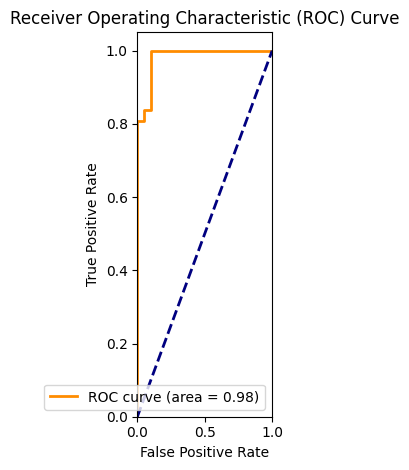

In [50]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

**🔵 Receiver Operating Characteristic (ROC) Curve¶**

* 🔍 Interpretation
True Positive Rate vs. False Positive Rate: The ROC curve plots the true positive rate against the false positive rate at various threshold settings.
ROC Curve (orange line): Indicates the performance of the model. The curve closer to the top left corner signifies a better performance.
Area Under the Curve (AUC): The AUC is 0.97, indicating excellent model performance. An AUC of 1.0 represents a perfect model, while an AUC of 0.5 represents a model with no discrimination capability.
* 📈 Insights
High AUC: The model has a high AUC of 0.97, demonstrating its strong ability to distinguish between classes.
Optimal Threshold: The point closest to the top left corner represents the optimal threshold where the true positive rate is maximized and the false positive rate is minimized.

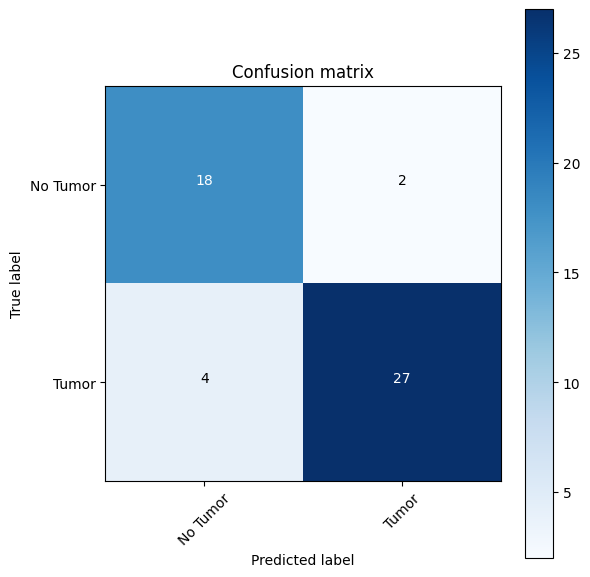

In [51]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, classes=['No Tumor', 'Tumor'])

#**Prediction**

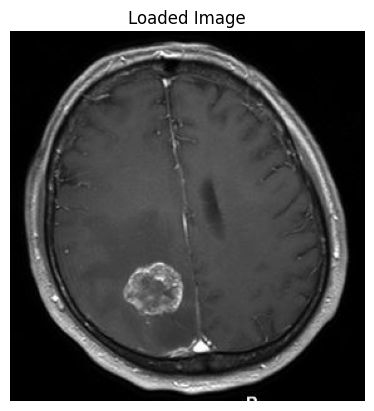

In [52]:
import cv2
import matplotlib.pyplot as plt

# Path to the new image
new_image_path = '/content/Y255.JPG'

# Load the image using OpenCV
img = cv2.imread(new_image_path)

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image using Matplotlib
plt.imshow(img_rgb)
plt.title('Loaded Image')
plt.axis('off')  # Hide the axis
plt.show()

In [53]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Function to preprocess a new image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(image_path, model):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class, prediction

# Load the trained model
model = load_model('/content/brain_tumor_detection_model.h5')

# Path to the new image
new_image_path = '/content/Y255.JPG'

# Make prediction
predicted_class, prediction = predict_image(new_image_path, model)

# Output the result
if predicted_class == 0:
    print("The model predicts: No brain tumor")
else:
    print("The model predicts: Brain tumor")

# Output the prediction probabilities
print("Prediction probabilities:", prediction)


1/1 [==============================] - 0s 343ms/step
The model predicts: Brain tumor
Prediction probabilities: [[0.00150414 0.9984958 ]]


#**Web Application using Streamlit**

In [54]:
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from PIL import Image

# Function to preprocess a new image
def preprocess_image(image):
    img = np.array(image)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(image, model):
    img = preprocess_image(image)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class, prediction

# Load the trained model
model = load_model('/content/brain_tumor_detection_model.h5')

# Streamlit app
st.title("Brain Tumor Detection")
st.write("Upload an MRI image to check for brain tumors")

# File uploader
uploaded_file = st.file_uploader("Choose an MRI image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded MRI Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Predict the class of the image
    predicted_class, prediction = predict_image(image, model)

    # Output the result
    if predicted_class == 0:
        st.write("The model predicts: No brain tumor")
    else:
        st.write("The model predicts: Brain tumor")

    # Output the prediction probabilities
    st.write("Prediction probabilities:", prediction)

# To run the app, save this file as app.py and run the command:
# streamlit run app.py


**how to run app.py in google collab**

In [55]:
!wget -q -O - ipv4.icanhazip.com

34.147.57.195


In [56]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.147.57.195:8501

npx: installed 22 in 2.719s
your url is: https://few-camels-hide.loca.lt
2024-07-17 08:40:06.325111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 08:40:06.325172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 08:40:06.326691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 08:40:07.664686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find T

**Conclusion**

By developing a CNN-based model for brain tumor detection from MRI images, this project aims to advance the field of medical imaging and provide a valuable tool for early and accurate diagnosis of brain tumors. The successful implementation of this project could lead to significant improvements in patient outcomes and healthcare efficiency.